In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import matplotlib
import numpy
from skimage import color, io
from skimage.transform import resize
from skimage.io import imsave

In [2]:
def loadImage(path):
    original_img = io.imread(path)[:,:,:3]
    L = color.rgb2lab(original_img)[:,:,0]
    
    img = resize(original_img, (256, 256), True)
    img = img.reshape((img.shape[0], img.shape[1], 3))
    img = img.astype(numpy.float32)
    img = color.rgb2lab(img)[:,:,0]
    return img.reshape((img.shape[0], img.shape[1], 1)), L, original_img

In [3]:
def loadGraph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

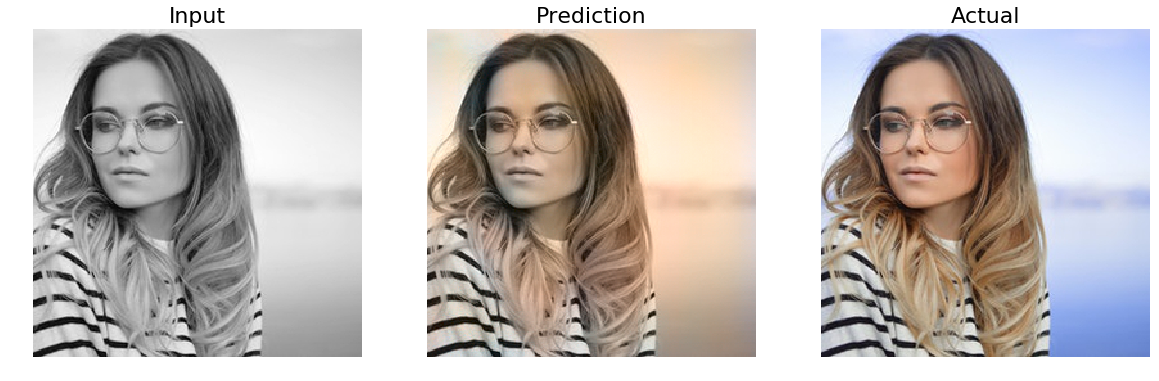

In [14]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
img, L, original_image = loadImage('../data/img_0.jpg')

graph = loadGraph("model/frozen_model.pb")

x = graph.get_tensor_by_name('prefix/batch:0')
y = graph.get_tensor_by_name('prefix/colorized_image:0')

filler = numpy.zeros((256, 256, 1))

with tf.Session(graph=graph) as sess:
    y_out = sess.run(y, feed_dict={
        x: [img],
    })
    
    rgb = color.lab2rgb(y_out[0].astype(numpy.float64))
    rgb = resize(rgb, (original_image.shape[0], original_image.shape[1]), True)
    lab = color.rgb2lab(rgb)
    
    final = numpy.zeros((original_image.shape[0], original_image.shape[1], 3))
    final[:,:,0] = L
    final[:,:,1] = lab[:,:,1]
    final[:,:,2] = lab[:,:,2]
    
    final = color.lab2rgb(final)
    
    plt.subplot(131)
    plt.title('Input', fontsize=22)
    plt.imshow(L, cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.title('Prediction', fontsize=22)
    plt.imshow(rgb)
    plt.axis('off')
    plt.subplot(133)
    plt.title('Actual', fontsize=22)
    plt.imshow(original_image)
    plt.axis('off')
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('results.png')